In [1]:
library(Seurat)
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggrepel)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Calculate age-subtype average expression
avgFile <- "./load_files/GALP_expr_avg_ratio_v2.Rdata"

if (!file.exists(avgFile)){
    seu <- readRDS(file = paste0("../../MF1/overview/load_files/All.MNN.v1.org.rds")) 
    fmeta <- readRDS(file = paste0("../../MF1/overview/load_files/Reanno_E37-110.org.meta.10052022.rds"))

    ## Only subset to a few genes to facilitate the calculation
    genes <- c("GALP", "NKX2-1", "FGF17", "GAL", "GALR1", "GALR2", "GALR3", "FGF17", "DLX1", "DLX2")
    subseu <- seu[genes, ]
    subseu <- subseu[, rownames(fmeta)]
    subseu@meta.data$subtype <- fmeta[colnames(subseu), "subtype"]
    subseu@meta.data$cbnage <- fmeta[colnames(subseu), "cbnage"]
    subseu[["avgcls"]] <- paste0(subseu$cbnage, "|", subseu$subtype)


    all_cls <- levels(as.factor(subseu$avgcls))

    ## mean expression ratios
    ratios <- lapply(all_cls, function(x) {
            message(paste0("Calculate expression ratio for cluster: ", x))
            data <- subseu$RNA@data[, subseu@meta.data$avgcls == x, drop = FALSE]
            er <- Matrix::rowMeans(data != 0)
            er
            }) %>% setNames(., all_cls) %>%
                as.data.frame(., check.names = FALSE) %>% 
                as.matrix()
    colnames(ratios) <- gsub("_", " ", colnames(ratios))

    ## Average expressiopn
    avgs <- lapply(all_cls, function(x) {
            message(paste0("Calculate average expression for cluster: ", x))
            data <- as.matrix(subseu$RNA@data[, subseu@meta.data$avgcls == x, drop = FALSE])
            avg <- rowMeans(expm1(data))
            avg
            }) %>% setNames(., all_cls) %>%
                as.data.frame(., check.names = FALSE) %>% 
                as.matrix()
    colnames(avgs) <- gsub("_", " ", colnames(avgs))
    logavgs <- log(avgs + 1)


    ## Only keep clusters with at least 300 cells
    expr_cls <- table(subseu$avgcls) %>%
                    .[.>= 30] %>% names()
    fratio <- ratios[, expr_cls]
    favg <- logavgs[, expr_cls]
    save(fmeta, logavgs, ratios, fratio, favg, file = avgFile)    
}

load(avgFile)

png 
  2

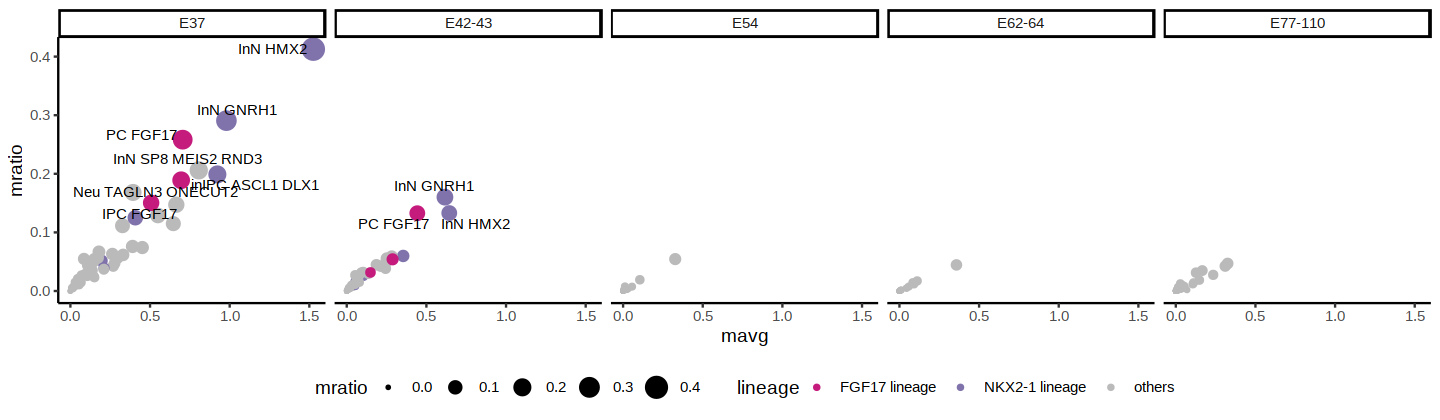

In [3]:
## Visualize GALP expression
pdata <- cbind(t(favg["GALP", ,drop = FALSE]), t(fratio["GALP", colnames(favg), drop = FALSE])) %>%
            as.data.frame() %>%
            setNames(., c("mavg", "mratio")) %>%
            tibble::rownames_to_column("agecls") %>%
            mutate(age = strsplit(agecls, "|", fixed = TRUE) %>% sapply(., "[", 1)) %>%
            mutate(cluster = strsplit(agecls, "|", fixed = TRUE) %>% sapply(., "[", 2))
pdata$nage <- gsub("E77-78|E93|E110", "E77-110", pdata$age) %>%
            factor(., levels = c("E37", "E42-43", "E54", "E62-64", "E77-110"))

pdata$cluster <- gsub("InN HMX1", "InN HMX2", pdata$cluster)
pdata$lineage <- ifelse(pdata$cluster %in% c("InN GNRH1", "InN HMX2", "InN LHX8 ZIC1", 
                                             "inIPC ASCL1 DLX1", "AntVen NKX2-1 LMO1", 
                                             "AntVen NKX2-1 NKX6-2"), "NKX2-1 lineage", "others")
pdata$lineage[pdata$cluster %in% c("PC FGF17", "IPC FGF17", "Neu TAGLN3 ONECUT2")] <- "FGF17 lineage"


lbdata <- filter(pdata, mratio >= 0.1 & mavg >= 0.4) %>%
            group_by(nage) %>%
            top_n(7, wt = mratio)





p <- ggplot(pdata, aes(x = mavg, y = mratio, color = lineage, size = mratio)) +
            geom_point(shape = 16) +
            geom_text_repel(data = lbdata, mapping = aes(label = cluster), color = "black", seed = 1, size = 3) + 
            theme_classic() +
            scale_color_manual(values = 
                               c(`NKX2-1 lineage` = "#8073ac", `FGF17 lineage` = "#c51b7d", others = "#bababa")) +
            facet_grid(cols = vars(nage)) +
            theme(legend.position = "bottom")
options(repr.plot.width=12, repr.plot.height=3.5, res = 300)
p
pdf(paste0("./report/", "GALP_expr.pdf"), width = 10, height = 3, useDingbats = FALSE)
print(p)
dev.off()

In [4]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggrepel_0.8.2 ggplot2_3.3.0 Matrix_1.2-18 dplyr_1.0.7   Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RCo